The concepts that this notebook will illustrate are:
* Writing kernel regression functions
* Using list comprehensions to generate data
* Using lambda functions to pass functions to other functions
* Basic plotting

# Kernel density estimators

Kernel functions are ideally: 
1. Non-negative
2. Bounded
3. Symmetric
4. Differentiable

In this notebook, we will define various kernels (some reasonable, others less so), and test their performance against each other in a simulation.

Consider the following kernel functions:

\begin{align}
K_1(u) &= \begin{cases}
1/2, |u| < 1 \\ 
0, else
\end{cases} \\ 
K_2(u) &= \begin{cases}
\frac{1-u}{2}, |u| < 1 \\
0, else
\end{cases} \\ 
K_3(u) &= \begin{cases}
\cos(\frac{\pi x}{2h}), |u| < 1 \\
0, else
\end{cases}
\end{align}

Let's program a simulation that takes each of these and plots it against the true density.

In [8]:
import numpy as np
from scipy.stats import distributions as iid
import random
from matplotlib import pyplot as plt

In [18]:
# 1. create data with a (strange) density
def dgp(N):
    x1 = iid.norm(loc = 5).rvs(int(np.floor(N/2)))
    x2 = iid.norm(loc = 10).rvs(int(np.ceil(N/2)))
    x = np.concatenate((x1, x2))
    # randomly set a bunch to 0
    zeros = random.sample(range(len(x)), int(np.floor(N/3)))
    x[zeros] = 0
    return x

[Text(0.5, 0, 'X Values'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Histogram of X')]

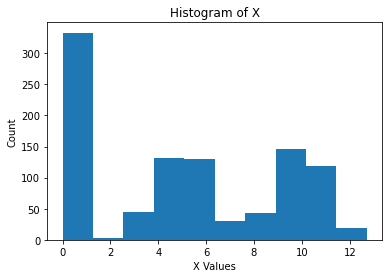

In [45]:
# generate data
N = 1000
X = dgp(N)

# plot
fig, ax = plt.subplots()
ax.hist(X)
ax.set(xlabel='X Values', ylabel='Count',title="Histogram of X")

One trick that will help us with these indicator functions is that the boolean ``True`` in python evaluates to 1. So we can multiply our expressions by a boolean that checks if the conditional is satisfied to push everything else outside to 0.

In [28]:
print(sum([True, False, True]))
print((1 < 2)*5)
print((1 > 2)*5)

2
5
0


Now let's make a list of (anonymous) kernel functions that we will later loop over to estimate the kernel density function at each point in x. These functions will be a function of $u$.

In [72]:
kernels = {"Uniform" : lambda u: (1/2)*(np.abs(u) < 1),
           "Linear" : lambda u: 1/2*(1-u)*(np.abs(u) < 1),
           "Cosine" : lambda u: np.cos(np.pi/2*u)*(np.abs(u) < 1)}

# test
kernels["Linear"](.8)

0.09999999999999998

Now for each kernel, we want to estimate it at each point in the data. Let's also loop over a few bandwidths just for fun. We'll do 2 bandwidths which implies 6 total plots. The idea is:

```
for each bandwidth and each kernel:
    calculate f_hat(x) = (1/nh) \sum_i k((x_i - x)/h) for each x in the data
```

For readability, let's write f_hat as a function first. ``f_hat()`` needs to know:
* The kernel function k()
* h
* x
* The data X

In [73]:
def f_hat(x, X, h, k):
    n = len(X)
    
    return (1/(n*h))*np.sum([k((x_i - x)/h) for x_i in X])

# test
f_hat(0, X, 5, kernels["Linear"])

0.036219659097219345

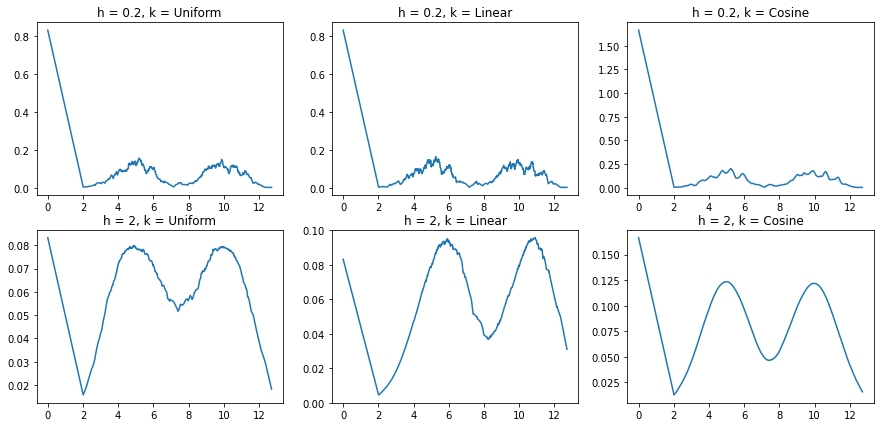

In [75]:
# initialize figure space
fig, ax = plt.subplots(2, 3, figsize=(15,7))
# sort X so we move across the axis
X = np.sort(X)

# counter is for axis positioning
counter = 0

for h in [.2, 2]: # loop over bandwidths
    for name, k in kernels.items(): # loop over kernel names, functions
        # row moves to 1 after 3rd iteration
        if counter < 3:
            row = 0
        else:
            row = 1
        # calculate fhat for each x, plot against x
        ax[row, counter % 3].plot(X, [f_hat(x, X, h, k) for x in X])
        # label 
        ax[row, counter % 3].set_title(f'h = {h}, k = {name}')
        # move counter forward
        counter += 1
        